In [34]:
import pandas as pd
TrainingFeatures = pd.read_csv('Cleaned Datasets/training_cleaned.csv', index_col='id')
TestFeatures = pd.read_csv('Cleaned Datasets/test_cleaned.csv', index_col='id')
TrainingLabels = pd.read_csv('Datasets/Training labels.csv', index_col='id')

Removed due to postprocessing insights

In [20]:
unimportant = ['population','gps_height','longitude','latitude','basin','subvillage','region_code','permit','public_meeting','district_code']

TrainingFeatures.drop(unimportant,axis = 1,inplace=True)
TestFeatures.drop(unimportant,axis = 1,inplace=True)

In [35]:
TrainingFeatures['funder'].fillna('nan',inplace=True)
#TrainingFeatures['subvillage'].fillna('nan',inplace=True)
TrainingFeatures['management_cross'].fillna('nan',inplace=True)

TestFeatures['funder'].fillna('nan',inplace=True)
#TestFeatures['subvillage'].fillna('nan',inplace=True)
TestFeatures['management_cross'].fillna('nan',inplace=True)

In [36]:
for object_col in TrainingFeatures.select_dtypes(include=['object']).columns:
    TrainingFeatures[object_col] = TrainingFeatures[object_col].astype('category')
    TestFeatures[object_col] = TestFeatures[object_col].astype('category')

Hyperopt tuning and cross validation

In [37]:
import hyperopt
import sys
import numpy as np

class ClassifierObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
        
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'depth': hyper_params['depth'],
            'l2_leaf_reg': hyper_params['l2_leaf_reg'],
            'max_ctr_complexity': hyper_params['max_ctr_complexity'],
            'subsample': hyper_params['subsample'],
            'model_size_reg': hyper_params['model_size_reg']
            }
    
    def __call__(self, hyper_params):

        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        scores = cb.cv(
            pool=self._dataset,
            params=params,
            fold_count=self._fold_count,
            verbose=False)
        max_multi_mean = np.max(scores['test-MultiClass-mean'])
        print(scores)
        self._evaluated_count += 1
        return {'loss': -max_multi_mean, 'status': hyperopt.STATUS_OK}

In [38]:
def find_best_hyper_params(dataset, const_params, max_evals):    

    parameter_space = {
    'learning_rate': hyperopt.hp.uniform('learning_rate', 0.01, 0.1),
    'depth': hyperopt.hp.randint('depth', 3, 10),
    'l2_leaf_reg': hyperopt.hp.uniform('l2_leaf_reg', 1, 10),
    'max_ctr_complexity': hyperopt.hp.randint('max_ctr_complexity', 0, 8),
    'subsample': hyperopt.hp.uniform('subsample', 0.6, 1.),
    'model_size_reg': hyperopt.hp.randint('max_bin', 0, 10) 
    }

    objective = ClassifierObjective(dataset=dataset, const_params=const_params, fold_count=6)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals)
    return best

def train_best_model(X, y, const_params,cat_col, max_evals):
    dataset = cb.Pool(X, y, cat_features=cat_col)
    
    best = find_best_hyper_params(dataset, const_params, max_evals=max_evals)
    hyper_params = best.copy()
    hyper_params.update(const_params)
    hyper_params.pop('use_best_model', None)
    
    model = cb.CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params

In [42]:
import catboost as cb

hyperopt_iterations = 10

const_params = dict({'task_type':"CPU",'eval_metric': 'MultiClass', 'iterations': 50,'bootstrap_type':'Bernoulli', 'loss_function':'MultiClass','boosting_type':'Ordered'})

model, params = train_best_model(
    TrainingFeatures, TrainingLabels, 
    const_params, 
    TrainingFeatures.select_dtypes(include=['category']).columns.values.tolist(),
    max_evals=hyperopt_iterations)

    iterations  test-MultiClass-mean  test-MultiClass-std  \
0            0              1.041061             0.000503   
1            1              0.994495             0.000504   
2            2              0.956403             0.000618   
3            3              0.924283             0.000632   
4            4              0.896587             0.000817   
5            5              0.872713             0.001699   
6            6              0.852397             0.002068   
7            7              0.834880             0.002528   
8            8              0.818513             0.002787   
9            9              0.802637             0.003455   
10          10              0.788983             0.004412   
11          11              0.775898             0.003873   
12          12              0.763026             0.003708   
13          13              0.752383             0.002789   
14          14              0.742105             0.002122   
15          15          

In [ ]:
params

{'depth': 5,
 'l2_leaf_reg': 8.824313712420231,
 'learning_rate': 0.013176605188537348,
 'max_bin': 5,
 'max_ctr_complexity': 7,
 'subsample': 0.8422325299247136,
 'task_type': 'CPU',
 'eval_metric': 'MultiClass',
 'iterations': 100,
 'bootstrap_type': 'Bernoulli',
 'loss_function': 'MultiClass',
 'boosting_type': 'Ordered'}

In [43]:
pd.DataFrame({'feature_importance': model.get_feature_importance(), 
              'feature_names': TrainingFeatures.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
17,35.494263,quantity
19,22.619132,waterpoint_type_group
10,19.299193,ward
9,15.545347,lga
14,3.930602,extraction_type_group
15,2.698304,payment
21,0.207756,age
1,0.205402,funder
13,0.000000,permit
20,0.000000,management_cross


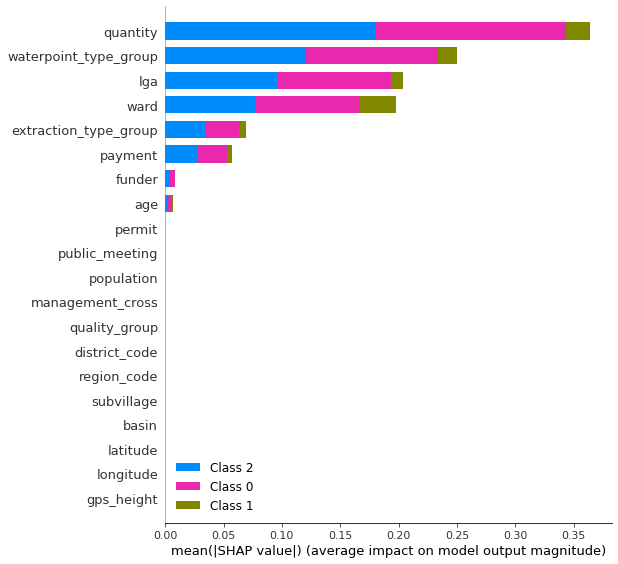

In [44]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(TestFeatures)
shap.summary_plot(shap_values, TestFeatures)

In [ ]:
preds = model.predict(TestFeatures)
preds_df = pd.DataFrame(preds, columns = ['status_group'], index = TestFeatures.index)

preds_df.to_csv('output.csv', index=True)